In [1]:
%matplotlib inline

%matplotlib inline
%load_ext autoreload
%autoreload 2

import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeat
import regionmask
import pandas as pd
from datetime import datetime, timedelta
import utils

In [2]:
runs = ['var', '2016', 'cos']

In [3]:
ds_base = {}
ds_emisbase = {}
ds_delta = {}
ds_emispulse = {}

for run in runs:
    ds_delta[run] = {}
    ds_emispulse[run] = {}

In [4]:
ds_base['global'] = xr.open_mfdataset(f'../GCrundirs/IRF_runs/BC_base/base_2016_jan_BC/OutputDir/GEOSChem.AerosolMass.2016*.nc4' )
ds_emisbase['global'] = xr.open_mfdataset(f'../GCrundirs/IRF_runs/BC_base/base_2016_jan_BC/OutputDir/HEMCO_diagnostics.2016*.nc' )

for run in runs:

    ds_delta[run]['global'] = xr.open_mfdataset(f'../GCrundirs/IRF_runs/BC_sustained/sust_{run}_jan_BC/OutputDir/GEOSChem.AerosolMass.2016*.nc4' )
    ds_emispulse[run]['global'] = xr.open_mfdataset(f'../GCrundirs/IRF_runs/BC_sustained/sust_{run}_jan_BC/OutputDir/HEMCO_diagnostics.2016*.nc' )


## Add in the area and dz

In [5]:
### import the regions we are interested in ###
ar6_coal_location = pd.read_csv('ar6_coal_location.csv', index_col = 'number').to_dict()['acronym']

In [6]:
height = pd.read_excel('gc_altitude.xlsx')

In [7]:
height_ds = height.diff().dropna().to_xarray().rename({'index':'lev'})
height_ds['lev'] = ds_base['global']['lev']
height_ds = height_ds.rename({'altitude':'dz'}) 
height_ds['dz']*=1e3


In [8]:
for run in runs:
    ds_delta[run]['global'] = xr.merge([ds_delta[run]['global'], height_ds], join = 'inner')
    ds_emispulse[run]['global'] = xr.merge([ds_emispulse[run]['global'], height_ds], join = 'inner')
ds_base['global'] = xr.merge([ds_base['global'], height_ds], join = 'inner')
ds_emisbase['global'] = xr.merge([ds_emisbase['global'], height_ds], join = 'inner')
    #ds_conc2x[run] = xr.merge([ds_conc2x[run], height_ds], join = 'inner')
    #ds_emis2x[run] = xr.merge([ds_emis2x[run], height_ds], join = 'inner')

In [9]:
for run in runs:
     utils.combine_BC(ds_emispulse[run]['global'])
utils.combine_BC(ds_emisbase['global'])

## Regional Comparison

In [10]:
full_loc = list(ar6_coal_location.values())
full_loc.append('global')

In [11]:
#### create a mask ####
regions = regionmask.defined_regions.ar6.land

for r in ar6_coal_location:
    mask = regions.mask(ds_delta['2016']['global'], lon_name = 'lon', lat_name = 'lat')
    contiguous_mask = ~np.isnan(mask)& (mask == r)
    for run in runs:
        #### mask our population dataset ####
        ds_emisbase[ar6_coal_location[r]] = ds_emisbase['global'].where(contiguous_mask)
        ds_emispulse[run][ar6_coal_location[r]] = ds_emispulse[run]['global'].where(contiguous_mask)
        ds_base[ar6_coal_location[r]] = ds_base['global'].where(contiguous_mask)
        ds_delta[run][ar6_coal_location[r]] = ds_delta[run]['global'].where(contiguous_mask)

In [12]:
ds_delta_r = {}
ds_base_r = {}
ds_emisbase_r = {}
ds_emispulse_r = {}
ds_conc2x_r = {}
ds_emis2x_r = {}
for run in runs:
    ds_delta_r[run] = {}
    ds_emispulse_r[run] = {}
    ds_conc2x_r[run] = {}
    ds_emis2x_r[run] = {}

In [13]:
for r in full_loc:
    ds_base_r[r] = ds_base[r].fillna(0)
    ds_emisbase_r[r] = ds_emisbase[r].fillna(0)
    for run in runs:
        #### mask our population dataset ####
        ds_emispulse_r[run][r] = ds_emispulse[run][r].fillna(0)
        ds_delta_r[run][r] = ds_delta[run][r].fillna(0)

In [14]:
Ndt = 90
dt = 1 #days
t_range = np.arange(0., dt*Ndt, dt)
Δt = 1


## Find G for each run

In [15]:
GC_out = {}
f0 = {}
for run in runs:
    GC_out[run] = {}
    f0[run] = {}

In [16]:
for run in runs:
    for r in full_loc:
        #ds_GF[run]['f'] = (utils.global_w_mean(ds_emis2x, 'EmisBC_Total') - utils.global_w_mean(ds_emisbase, 'EmisBC_Total'))
        #ds_GF[run]['f']= ds_GF[run]['f'].assign_coords(time = np.arange(0,len(f['time']))) #inputting a x2 until we get our doubled emissions as daily data
        GC_out[run][r]= utils.calc_δc_δt(ds_delta_r[run][r], ds_base_r[r], 'AerMassBC')
        GC_out[run][r]= GC_out[run][r].assign_coords(time = np.arange(0,len(GC_out[run][r]['time'])))

        f0[run][r] = (utils.global_w_mean(ds_emispulse_r[run][r], 'EmisBC_Total') - 
              utils.global_w_mean(ds_emisbase_r[r], 'EmisBC_Total')).isel(time = 0)

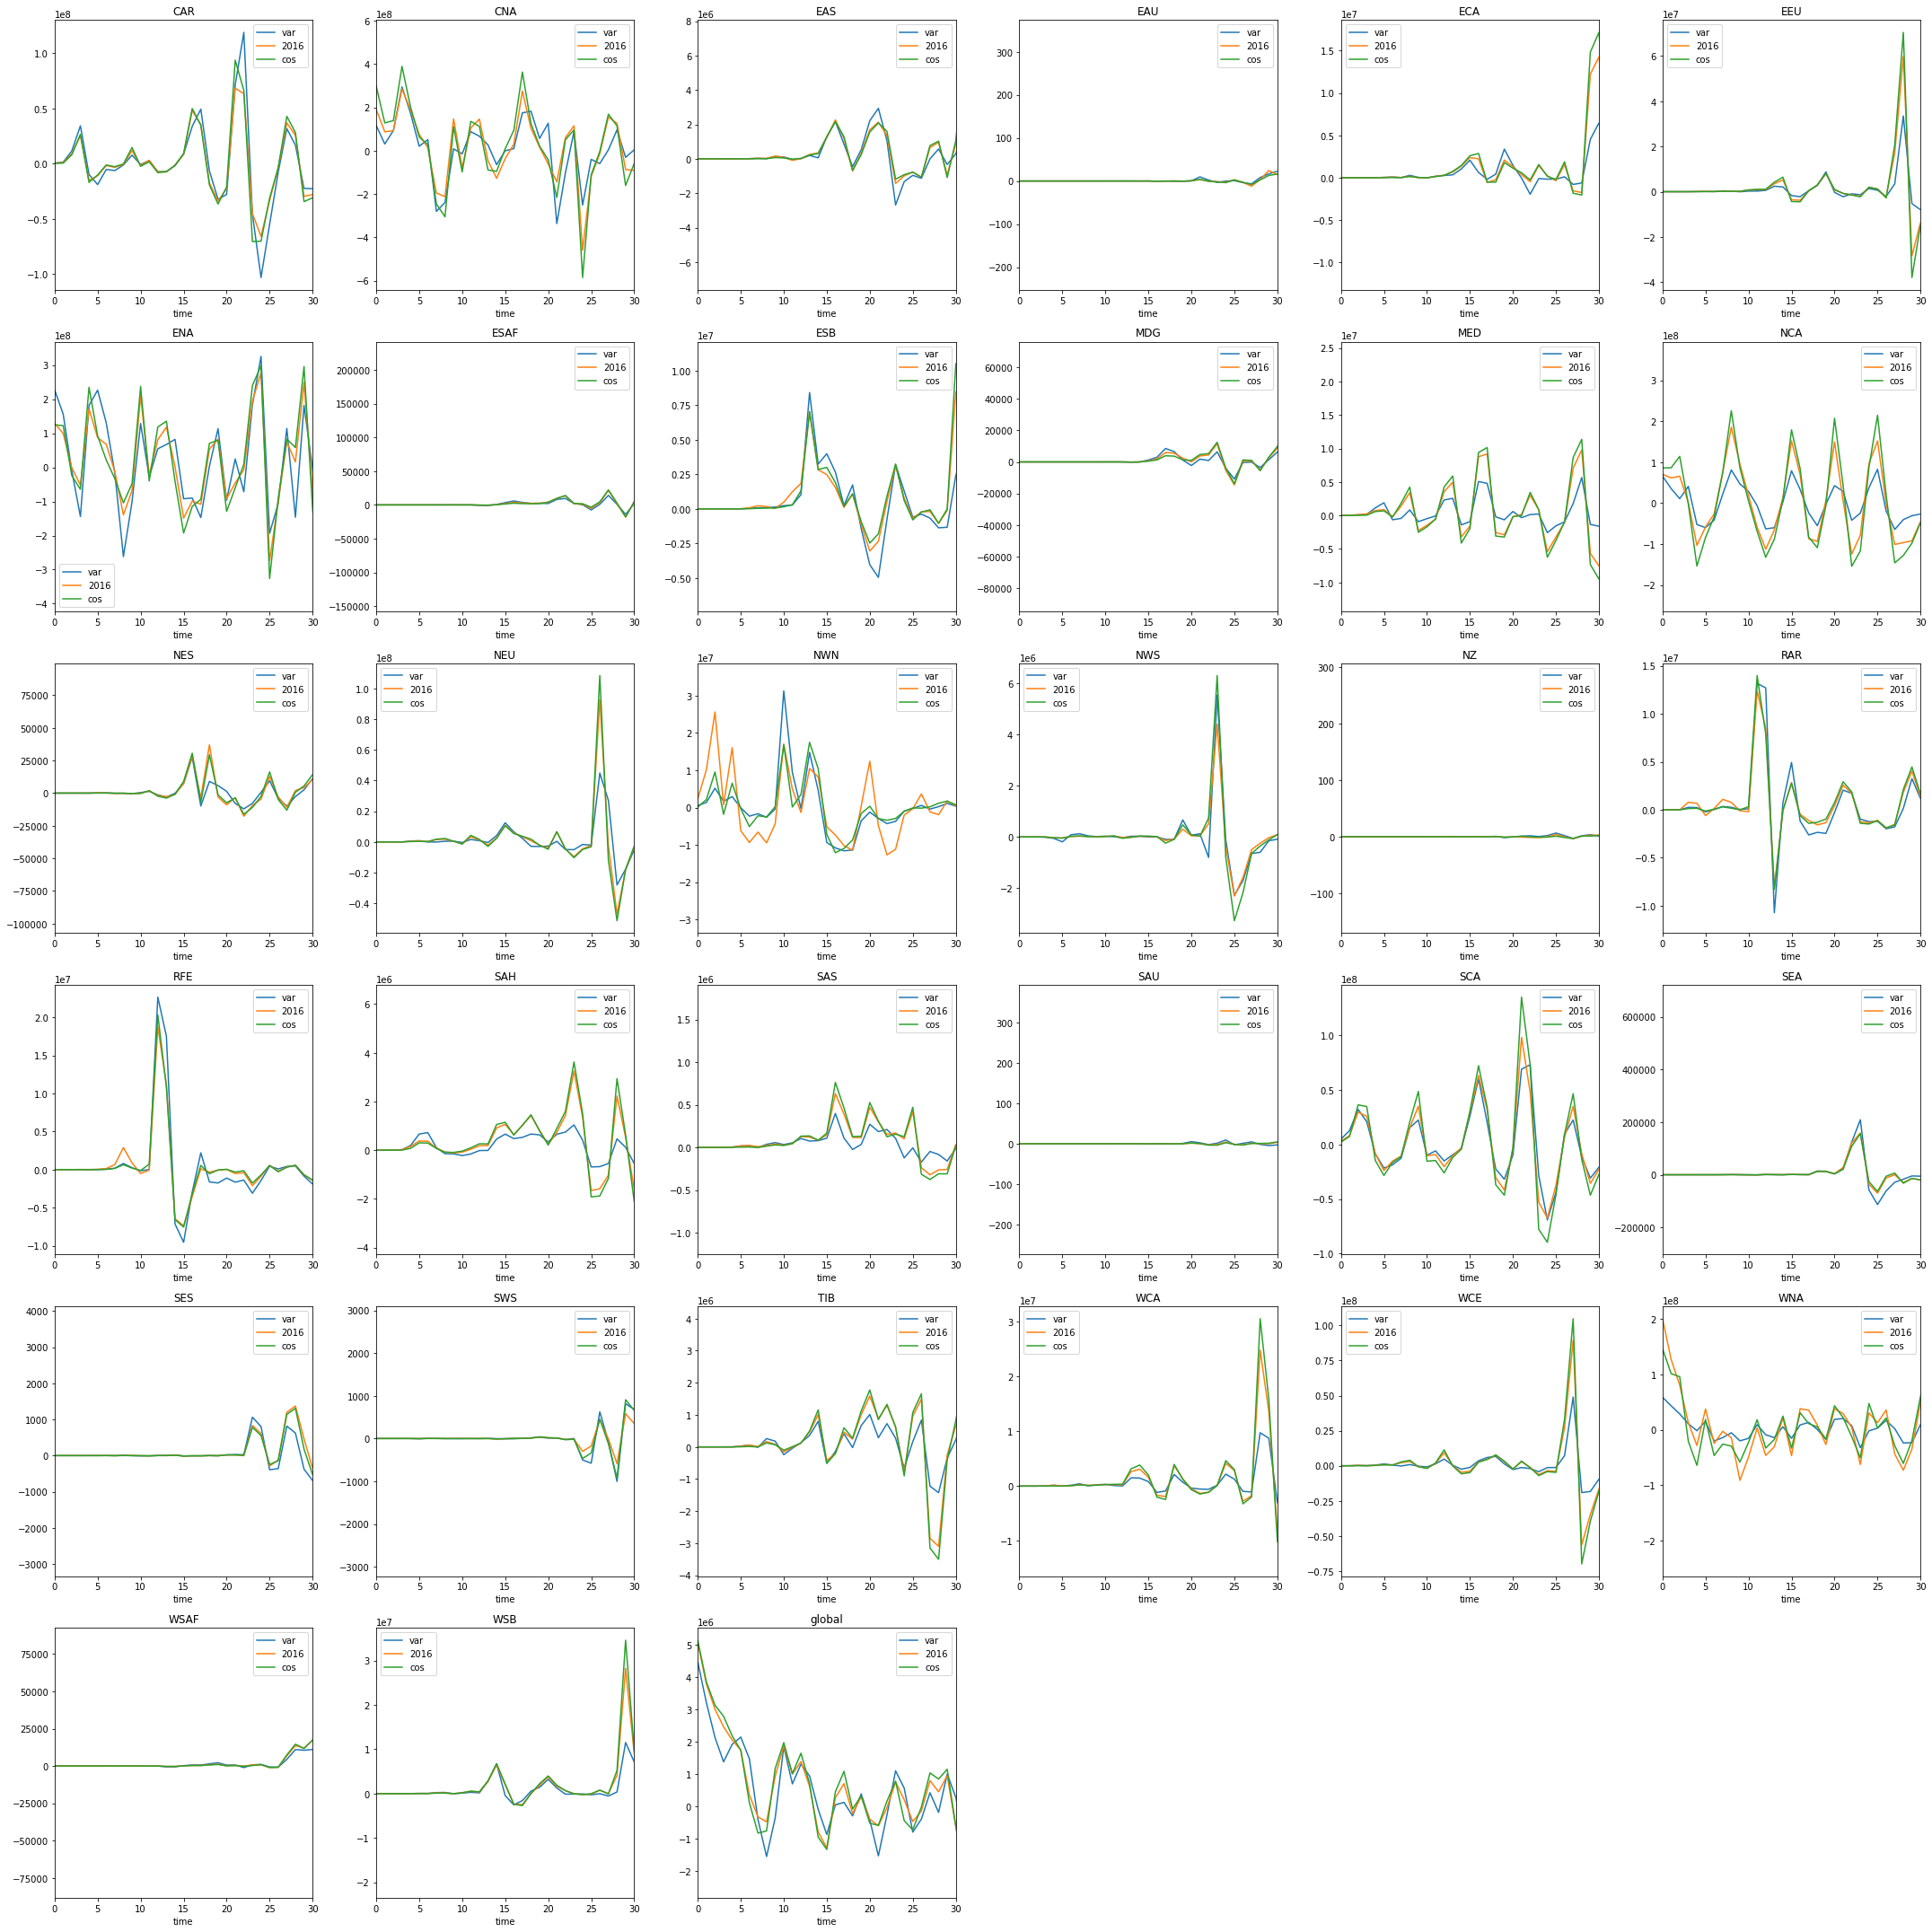

In [17]:
fig = plt.figure(figsize=(30,30))
for idx, r in enumerate(full_loc):
    ax = fig.add_subplot(6,6,idx+1)
    for idx, run in enumerate(runs):
        (GC_out[run][r]/f0[run]['global']).plot(label = run, ax = ax)
        plt.legend()
        plt.title(r)
        plt.xlim(0,30)
        plt.tight_layout()

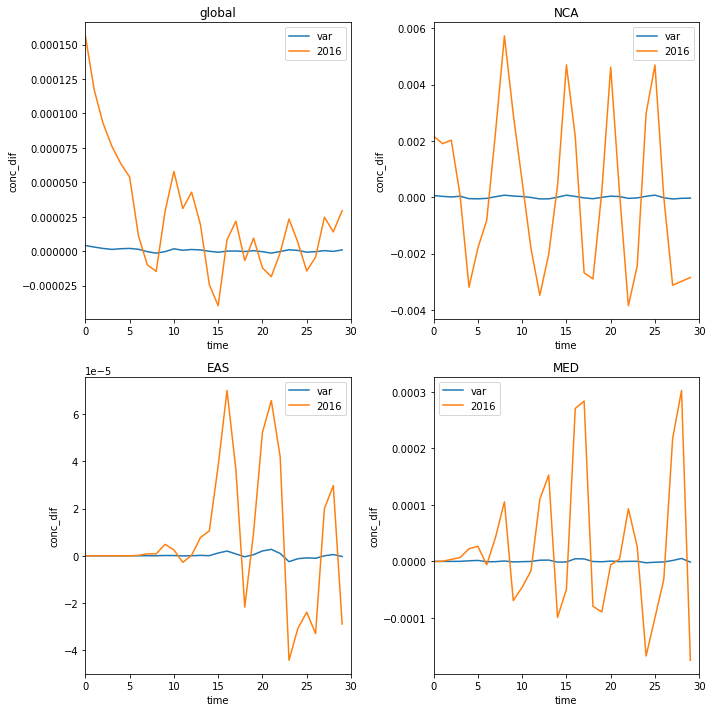

In [53]:
fig = plt.figure(figsize=(10,10))
for idx, r in enumerate(['global','NCA','EAS','MED']):
    ax = fig.add_subplot(2,2,idx+1)
    for idx, run in enumerate(runs):
        (GC_out[run][r]).plot(label = run, ax = ax)
        plt.legend()
        plt.title(r)
        plt.xlim(0,30)
        plt.tight_layout()